In [1]:
import torch
import torch.nn as nn
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split



print(torch.__version__)
device = 'cuda' if torch.cuda.is_available() else "cpu"
print(f'Using device: {device}')
%matplotlib ipympl

2.2.2+cu121
Using device: cuda


In [2]:
n_samples = 1000
n_features = 3
train_split = 0.8
num_classes = 10

X, y = make_blobs(n_samples, n_features, centers=num_classes, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(torch.from_numpy(X).type(torch.float32), torch.from_numpy(y).type(torch.float32), train_size=train_split)

# y_train = y_train.unsqueeze(-1)
# y_test = y_test.unsqueeze(-1)

y_train = nn.functional.one_hot(y_train.long(), num_classes,).type(torch.float32)
y_test = nn.functional.one_hot(y_test.long(), num_classes,).type(torch.float32)


len(X_train), len(X_test), len(y_train), len(y_test), X_train.shape, y_train.shape

(800, 200, 800, 200, torch.Size([800, 3]), torch.Size([800, 10]))

Text(0.5, 0, 'Z-axis')

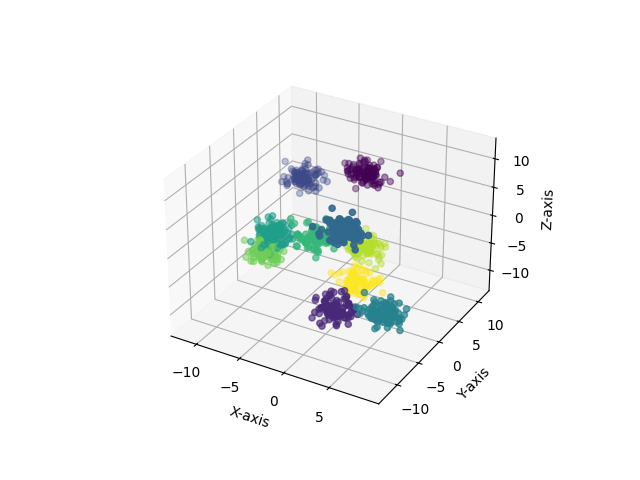

In [3]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y)

ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')

In [4]:
class MultiClassModel(nn.Module):
    def __init__(self, num_in_features, num_classes):
        super().__init__()
        self.num_classes = num_classes
        self.num_features = num_in_features
        self.seq = nn.Sequential(
            nn.Linear(self.num_features, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, self.num_classes),
        )
    
    def forward(self, X):
        return self.seq(X)

In [49]:
model = MultiClassModel(num_in_features=X.shape[1], num_classes=num_classes).to(device)

optim = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

In [50]:
def save_state(save_path: Path, model: nn.Module, optim: torch.optim.Optimizer, epoch: int):
    model_state = model.state_dict()
    optim_state = optim.state_dict()
    state = {
        'epoch': epoch,
        'model_state': model_state,
        'optim_state': optim_state,
    }
    torch.save(state, save_path)
    print('State Saved.')


def train(model: nn.Module, X_train: torch.Tensor, y_train: torch.Tensor, X_val: torch.Tensor, y_val: torch.Tensor, num_epochs: int, save_path: Path):
    X_train = X_train.to(device)
    y_train = y_train.to(device)
    X_val = X_val.to(device)
    y_val = y_val.to(device)
    
    epochs = []
    losses = []
    accs = []
    val_losses = []
    val_accs = []
    
    for epoch in range(num_epochs):
        model.train()
        
        y_preds = model(X_train)
        loss = loss_fn(y_preds, y_train)
        
        optim.zero_grad()
        loss.backward()
        optim.step()
        
        model.eval()
        with torch.inference_mode():
            val_preds = model(X_val)
            val_loss = loss_fn(val_preds, y_val)
        
        y_preds = torch.argmax(y_preds, -1).type(torch.float32)
        val_preds = torch.argmax(val_preds, -1).type(torch.float32)
        
        yt = torch.argmax(y_train, dim=-1).type(torch.float32).cpu().numpy()
        yv = torch.argmax(y_val, dim=-1).type(torch.float32).cpu().numpy()
        
        # print(yt.shape, y_preds.shape)
        # print(y_train)
        
        acc = accuracy_score(yt, y_preds.cpu().numpy())
        val_acc = accuracy_score(yv, val_preds.cpu().numpy())
        
        
        if epoch % 25 == 0:
            
            if len(val_losses) == 0 or val_loss.detach().cpu().numpy() < np.min(val_losses):
                save_state(save_path, model, optim, epoch)
            
            
            epochs.append(epoch)
            losses.append(loss.detach().cpu().numpy())
            val_losses.append(val_loss.cpu().numpy())
            accs.append(acc)
            val_accs.append(val_acc)
            
            print(f'Epoch {epoch}/{num_epochs}:\n\tLoss: {loss:0.4f} | Acc: {acc:0.4f} | Val_Loss: {val_loss:0.4f} | Val_Acc: {val_acc:0.4f}')
        
        
        
        

In [51]:
num_epochs = 1200

save_dir = Path('models')
save_path = save_dir / 'simple_multiclass_classifier.pth'

train(model, X_train, y_train, X_test, y_test, num_epochs, save_path)

State Saved.
Epoch 0/1200:
	Loss: 2.5085 | Acc: 0.0000 | Val_Loss: 2.4141 | Val_Acc: 0.0000
State Saved.
Epoch 25/1200:
	Loss: 1.5489 | Acc: 0.7375 | Val_Loss: 1.5143 | Val_Acc: 0.7750
State Saved.
Epoch 50/1200:
	Loss: 0.9365 | Acc: 0.8600 | Val_Loss: 0.9283 | Val_Acc: 0.8850
State Saved.
Epoch 75/1200:
	Loss: 0.5479 | Acc: 0.9250 | Val_Loss: 0.5384 | Val_Acc: 0.9550
State Saved.
Epoch 100/1200:
	Loss: 0.3214 | Acc: 0.9750 | Val_Loss: 0.3136 | Val_Acc: 0.9950
State Saved.
Epoch 125/1200:
	Loss: 0.2088 | Acc: 0.9762 | Val_Loss: 0.1995 | Val_Acc: 0.9950
State Saved.
Epoch 150/1200:
	Loss: 0.1533 | Acc: 0.9750 | Val_Loss: 0.1430 | Val_Acc: 0.9950
State Saved.
Epoch 175/1200:
	Loss: 0.1224 | Acc: 0.9762 | Val_Loss: 0.1114 | Val_Acc: 0.9950
State Saved.
Epoch 200/1200:
	Loss: 0.1036 | Acc: 0.9750 | Val_Loss: 0.0923 | Val_Acc: 0.9900
State Saved.
Epoch 225/1200:
	Loss: 0.0913 | Acc: 0.9762 | Val_Loss: 0.0800 | Val_Acc: 0.9900
State Saved.
Epoch 250/1200:
	Loss: 0.0828 | Acc: 0.9775 | Val_Lo

In [52]:
states = torch.load(save_path)
states.keys()

dict_keys(['epoch', 'model_state', 'optim_state'])

In [54]:
model1 = MultiClassModel(num_in_features=X.shape[1], num_classes=num_classes).to(device)
model1.load_state_dict(states['model_state'])

<All keys matched successfully>

In [69]:
model1.eval()
with torch.inference_mode():
    preds = model1(X_test.to(device))

preds = torch.argmax(preds, dim=-1)

In [65]:
(preds.type(torch.int16).sum() / preds.shape[0]).cpu().numpy()

array(0.98999995, dtype=float32)

In [70]:
preds.cpu().numpy()

array([5, 6, 1, 1, 1, 6, 8, 6, 5, 1, 2, 2, 9, 0, 6, 3, 3, 0, 2, 0, 3, 8,
       1, 6, 0, 3, 1, 8, 6, 3, 8, 3, 6, 9, 5, 5, 2, 9, 2, 7, 9, 7, 3, 3,
       5, 0, 9, 0, 6, 6, 2, 9, 7, 7, 6, 8, 3, 4, 7, 6, 5, 9, 1, 8, 2, 0,
       2, 3, 8, 5, 0, 2, 7, 9, 2, 9, 4, 4, 8, 9, 7, 9, 6, 1, 5, 1, 9, 9,
       4, 6, 6, 9, 7, 0, 5, 7, 6, 0, 0, 3, 5, 2, 9, 4, 9, 4, 6, 1, 1, 1,
       0, 1, 2, 4, 2, 7, 4, 4, 8, 3, 1, 1, 2, 7, 1, 3, 9, 4, 7, 7, 8, 1,
       8, 2, 0, 2, 0, 5, 4, 1, 1, 2, 0, 1, 3, 5, 6, 6, 6, 9, 2, 5, 7, 1,
       4, 1, 8, 7, 1, 5, 9, 1, 2, 0, 3, 3, 8, 1, 5, 1, 2, 8, 4, 9, 0, 8,
       4, 5, 2, 6, 8, 0, 5, 5, 4, 9, 5, 0, 4, 5, 8, 1, 2, 7, 2, 9, 3, 8,
       3, 9])

Text(0.5, 0, 'Z-axis')

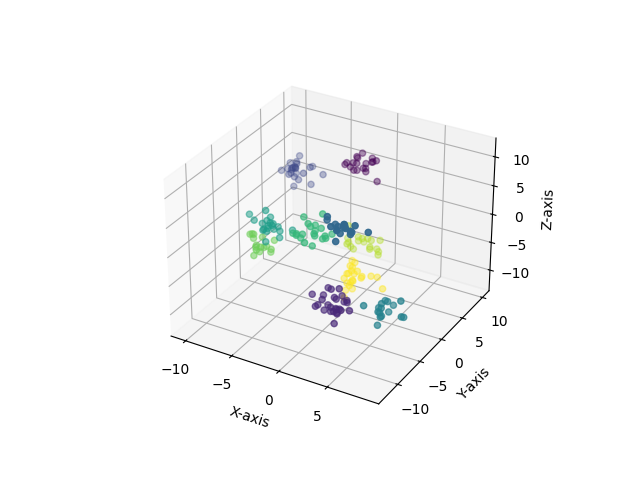

In [71]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(X_test[:, 0], X_test[:, 1], X_test[:, 2], c=preds.cpu().numpy())

ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')